## Hey There!
Modeling Approach: Transformer Network 

# Set up

In [ ]:
# @title Imports 
import pandas as pd
import numpy as np

import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight

from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras.layers.embeddings import Embedding
from keras.metrics import AUC
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import random
import os
import json



import matplotlib.pyplot as plt
from IPython.display import clear_output 

pd.set_option('display.max_columns', None)

Connect to TPU

In [ ]:
## Connect to TPU ##

# TPU Configuration
resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='')
tf.config.experimental_connect_to_cluster(resolver)
# This is the TPU initialization code that has to be at the beginning.
tf.tpu.experimental.initialize_tpu_system(resolver)
print("All devices: ", tf.config.list_logical_devices('TPU'))

a = tf.constant([[1.0, 2.0, 3.0], [4.0, 5.0, 6.0]])
b = tf.constant([[1.0, 2.0], [3.0, 4.0], [5.0, 6.0]])

with tf.device('/TPU:0'):
  c = tf.matmul(a, b)
print("c device: ", c.device)
print(c)
strategy = tf.distribute.TPUStrategy(resolver)

# Clear ouput 
clear_output()

In [ ]:
# Connect to Drive 
from google.colab import drive
drive.mount('/content/drive')
clear_output()

#Data Preprocessing / Normalization 

Get and Preprocess X

We should come up with a better long-term solution for the issue of not being able to load data easily :|


In [ ]:
file_location_spencer: str = '/content/drive/MyDrive/DS4H/Data/wideX_Smoothed.csv'
file_location_franklin: str = '/content/drive/MyDrive/Colab Notebooks/Sleep Disorder Project/Project Code + Data/Minute-by-Minute Data/Wide Data [Smoothed]/wideX_Smoothed.csv'

In [ ]:
#Load data
Wide_X = pd.read_pickle('/content/drive/MyDrive/Colab Notebooks/Sleep Disorder Project/Project Code + Data/Minute-by-Minute Data/Wide Data [Smoothed]/wideX_Smoothed.pkl')
#Wide_X = Wide_X.drop("Unnamed: 0", axis = 1)

#Wide_X.fillna(0)
Wide_X = Wide_X.where(Wide_X > 0.0000001, 0)

In [ ]:
Wide_X

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
# Seperate SEQN from dataframe
SEQN = Wide_X.pop("SEQN")
data_wide = Wide_X

# Normalize from 0.01 to 1
scaler = MinMaxScaler()
scaler.fit(data_wide)
data_wide = scaler.transform(data_wide)

# Convert DF to array
data_wide = np.array(data_wide)

# Set 3-D shape
data_wide = data_wide.reshape(len(data_wide),len(data_wide[0]),1)
data_wide = data_wide.astype(np.float32)
# Set shape for model
data_wide_shape = (data_wide.shape[1],data_wide.shape[2])



print("Shape:", data_wide.shape)

Shape: (5429, 10080, 1)


Preprocess y

In [ ]:
# Load Data Y ----
Y = pd.read_pickle('/content/drive/MyDrive/Colab Notebooks/Sleep Disorder Project/Project Code + Data/Minute-by-Minute Data/Wide Data [Smoothed]/y.pkl')
#Y = Y.drop("Unnamed: 0", axis = 1)
#Make y array as well 
y = np.hstack(np.asarray(Y)).reshape(len(Y),1)
print(y.shape)
y = y.astype(np.float32)

(5429, 1)


### Stratified Train Test Split

In [ ]:
# Train Test Split
X_train, X_test, y_train, y_test, ids_train, ids_test = train_test_split(data_wide, y, SEQN, test_size=0.2, stratify = y, random_state = 41)

# Train Validation Split
X_trainB, X_valB, y_trainB, y_valB, ids_trainB, ids_valB = train_test_split(X_train, y_train, ids_train, test_size=0.2, stratify = y_train, random_state = 32)

# Modeling!

In [ ]:
# @title Model Packages
# Packages
import pandas as pd
#import matplotlib.pyplot as plt
import numpy as np
#import random
#import pyreadstat
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight

from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras.layers.embeddings import Embedding
from keras.metrics import AUC

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from keras.layers import Attention
from keras.layers import MultiHeadAttention


from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Bidirectional
from keras.layers import Dropout, Flatten
from keras.layers.core import Activation
from keras.regularizers import L1L2


### Transformer Material

In [ ]:
# Number of Classes
n_classes = 2

def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    # Normalization and Attention
    x = layers.LayerNormalization(epsilon=1e-6)(inputs)
    x = layers.MultiHeadAttention(
        key_dim=head_size, num_heads=num_heads, dropout=dropout 
    )(x, x)
    x = layers.Dropout(dropout)(x)
    res = x + inputs

    # Feed Forward Part
    x = layers.LayerNormalization(epsilon=1e-6)(res)
    x = layers.Conv1D(filters=ff_dim, kernel_size=1, activation="relu")(x)
    x = layers.Dropout(dropout)(x)
    x = layers.Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)
    return x + res

Make Model

In [ ]:
def build_model(
    input_shape,
    head_size,
    num_heads,
    ff_dim,
    num_transformer_blocks,
    mlp_units,
    dropout=0,
    mlp_dropout=0,
):
    inputs = keras.Input(shape=input_shape)
    x = inputs
    for _ in range(num_transformer_blocks):
        x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)

    x = layers.GlobalAveragePooling1D(data_format="channels_first")(x)
    for dim in mlp_units:
        x = layers.Dense(dim, activation="relu")(x)
        x = layers.Dropout(mlp_dropout)(x)
    outputs = layers.Dense(1, activation="sigmoid")(x)
    return keras.Model(inputs, outputs)

Compile Model 

In [ ]:
from keras import optimizers

# designate input shape
input_shape = X_trainB.shape[1:]
# Compile Model 
with strategy.scope():
  model = build_model(
      input_shape,
      head_size=256,
      num_heads=1,
      ff_dim=128,
      num_transformer_blocks=1,
      mlp_units=[96],
      mlp_dropout=0.4,
      dropout=0.25,
  )
  model.compile(
      loss= tf.keras.losses.BinaryCrossentropy(from_logits=False),
      optimizer=keras.optimizers.Adam(learning_rate=1e-4),
      metrics= tf.keras.metrics.AUC(name='auc')
  )

# Save Model 
model.save_weights("reset_weights.h5")

def reset_model():
  model.load_weights("reset_weights.h5")

## Model Visuals

In [ ]:
# Model Summary
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 10080, 1)]   0           []                               
                                                                                                  
 layer_normalization (LayerNorm  (None, 10080, 1)    2           ['input_1[0][0]']                
 alization)                                                                                       
                                                                                                  
 multi_head_attention (MultiHea  (None, 10080, 1)    449         ['layer_normalization[0][0]',    
 dAttention)                                                      'layer_normalization[0][0]']    
                                                                                              

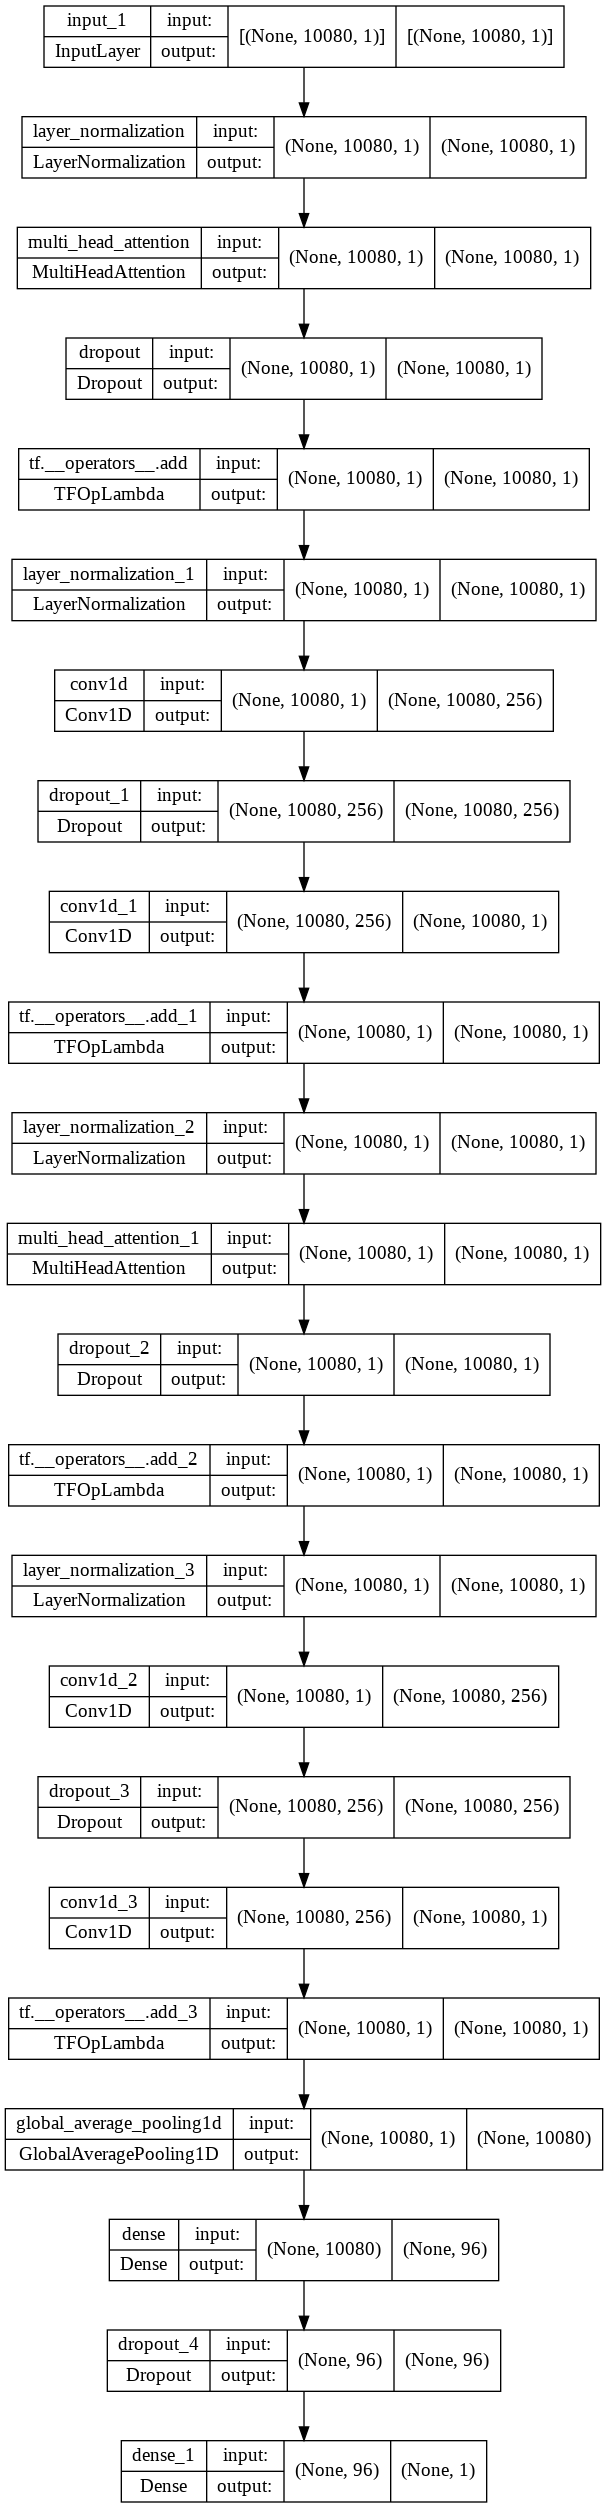

In [ ]:
# Plot Model Architecture 
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

##Train Model 

In [ ]:
## Parameters##

# Save Best Weights 
filepath = "VAL-AUC-impr(fr).h5"

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath, #=checkpoint_filepath,
    verbose = 1,
    monitor='val_auc',
    mode='max',
    save_best_only=True)


# Balance Weights 
n_sd = sum(y)
n_no_sd = len(y) - n_sd
class_weights = {0: (n_no_sd/len(y)),                # Custom Setting Class Weights 
                1: (n_sd/len(y))}

In [ ]:
# Fit model                                              
tf.keras.backend.clear_session()
history = model.fit(
    X_trainB, y_trainB,
    validation_data=(X_valB, y_valB),
    epochs=150, 
    batch_size= 64, # Change size 
    shuffle=False,
    verbose = 1,
    class_weight=class_weights,
    callbacks=[model_checkpoint_callback]
)

Epoch 1/500
55/55 [==============================] - ETA: 0s - loss: 0.0874 - auc: 0.5210
Epoch 1: val_auc improved from -inf to 0.56896, saving model to VAL-AUC-impr(fr).h5
55/55 [==============================] - 30s 396ms/step - loss: 0.0874 - auc: 0.5210 - val_loss: 0.5050 - val_auc: 0.5690
Epoch 2/500
55/55 [==============================] - ETA: 0s - loss: 0.0565 - auc: 0.5648
Epoch 2: val_auc improved from 0.56896 to 0.58049, saving model to VAL-AUC-impr(fr).h5
55/55 [==============================] - 12s 219ms/step - loss: 0.0565 - auc: 0.5648 - val_loss: 0.4397 - val_auc: 0.5805
Epoch 3/500
55/55 [==============================] - ETA: 0s - loss: 0.0520 - auc: 0.5785
Epoch 3: val_auc did not improve from 0.58049
55/55 [==============================] - 12s 215ms/step - loss: 0.0520 - auc: 0.5785 - val_loss: 0.4309 - val_auc: 0.5781
Epoch 4/500
55/55 [==============================] - ETA: 0s - loss: 0.0511 - auc: 0.5729
Epoch 4: val_auc did not improve from 0.58049
55/55 [====

KeyboardInterrupt: ignored

## Graphing

Evaulate 

In [ ]:
history_df = pd.DataFrame({'auc':history.history['auc'], 'val_auc':history.history['val_auc']})
history_df.to_csv("history_df.csv", index = False)

# Plot history: AUC
plt.plot(history_df['auc'], label='Training')
plt.plot(history_df['val_auc'], label='Validation')
plt.title('AUC')
plt.ylabel('AUC')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()
plt.savefig('')

In [ ]:
# Evaluate 
model.evaluate(X_test, y_test, batch_size = 64)
#Keras Test AUC
from keras.models import load_model
test_set_model = keras.models.load_model('VAL-AUC-impr(fr).h5')
results = test_set_model.evaluate(X_test, y_test, batch_size = 64)
print("--------------------------")
print(f'Keras Model Loading Test AUC: {round(results[1],2)}')
print("--------------------------")


#SKLearn Test AUC 
preds = test_set_model.predict(X_test)
from sklearn.metrics import r2_score, roc_auc_score
print(f'SKLearn Test AUC: {round(roc_auc_score(y_test, preds),3)}')
print("--------------------------")
plt.plot(preds)
plt.title('Predictions for Test Set')
plt.show()
plt.scatter(y_test, preds)

#K-Fold Cross Validation

In [ ]:
%%time
from sklearn.model_selection import StratifiedKFold

# Global Score List Buckets
cv_test_scores=[]
cv_val_scores=[]

# K fold parameters 
seed = 7
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)

# run K-fold 
count = 1
for train, val in kfold.split(X_train, y_train):
  
  # Create New Training Set 
  X_training = X_train[train]
  y_training = y_train[train]
  # Create new Validation Sets 
  X_val = X_train[val]
  y_val = y_train[val]

  # Reset model 
  print("Resetting model..")
  reset_model()
  # Checkpoints
  filepath = "VAL-AUC-impr(fr)" + str(count) +".h5"

  model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath, #=checkpoint_filepath,
    verbose = 2,
    monitor='val_auc',
    mode='max',
    save_best_only=True)

  # fit model   
  tf.keras.backend.clear_session()
  history = model.fit(
      X_training, y_training,
      validation_data=(X_val, y_val),
      epochs=200, # Make Epochs larger
      batch_size= 64, # Change size 
      shuffle=False,
      verbose = 1,
      class_weight=class_weights,
      callbacks=[model_checkpoint_callback]
  )


 
  # Eval model 
  # model_eval()
  from keras.models import load_model
  test_set_model = keras.models.load_model(filepath)
  print(" \n-\n-\n-\n-\n-\n-\n-\n-\n-\ntest set:")
  scores = test_set_model.evaluate(X_test, y_test, batch_size=64) # Test Set
  cv_test_scores.append(scores[1])
  print(" \n-\n-\n-\n-\n-\n-\n-\n-\n-\nval set:")
  scores = test_set_model.evaluate(X_val, y_val, batch_size=64)  # Validation Set
  cv_val_scores.append(scores[1])



  # Save model 
  print("Saving model...")
  #save_model(count)
  # Save files
  print("Saving files...")
  #save_files(count)

  # increment 
  print("FINISHED CYCLE NUMBER:", count)
  count += 1 

# Score Eval
print("\nCV Test AUC----------------------------")
print("Individual scores:", cv_test_scores)
print("Mean:", np.mean(cv_test_scores))
print("std:", np.std(cv_test_scores))
print("\nCV Val AUC-----------------------------")
print("Individual scores:", cv_val_scores)
print("Mean:", np.mean(cv_val_scores))
print("std:", np.std(cv_val_scores))